# Using Keras ImageDataGenerator
Here I'm using Keras [`ImageDataGenerator`](https://keras.io/preprocessing/image/) to read files from the `train` directory and feed a very simple CNN. I'm still not searching for accuracy here, just trying to simplify the pipeline. ImageDataGenerator has the ability to generate a flow of images to the CNN, applying:
* resampling to a smaller size
* changing to grayscale if needed
* train/validation split (still not done here)
* data augmentation

TODO:
* resample to a different size
* change the CNN to a more effective one
* ~~add the validation_generator and pass it to the model's `fit_generator` method~~
* analyze source data
* train on whole dataset
* data augmentation
* implement Mean Average Precision @ 5 for submission


In [1]:
import os
import math
import itertools
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, ZeroPadding2D, BatchNormalization, Add
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
from keras.models import Input, Model
from scipy.misc import imresize
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight


warnings.simplefilter("ignore", category=DeprecationWarning)

%matplotlib inline
pd.set_option("display.max_rows", 10)
np.random.seed(42)

Using TensorFlow backend.


In [2]:
os.listdir("../input/")

['train.csv', 'test', 'sample_submission.csv', 'train']

ImageDataGenerator requires `filename` and `class` respectively for the column with all the file names and for the other with the classes. Here I change the columns names but I could have used:

    x_col: string, column in the dataframe that contains
           the filenames of the target images.
    y_col: string or list of strings,columns in
           the dataframe that will be the target data.
in `flow_from_dataframe` method to override the default Keras behaviour

In [3]:
dataset = pd.read_csv("../input/train.csv")
dataset.columns = ['filename', 'class'] # renaming to match ImageDataGenerator expectations
dataset.sample(5)

,filename,class
20621,cfb8c68dc.jpg,new_whale
10152,66bf04895.jpg,w_b27b6c6
21324,d6a92a7f9.jpg,new_whale
16229,a37e5cc98.jpg,new_whale
4097,2a215f11e.jpg,new_whale


In [39]:
print(dataset.shape)

counts = pd.value_counts(dataset.iloc[:,1])

print('Total labels: ', len(counts))
cs = [1, 10, 50, 100]
for c in cs:
    print(f'Labels with at most {c} entries: ', len(counts[counts<=c]))
print(f'Most represented label is "{counts.index[0]}" with {counts[0] / dataset.shape[0] * 100}% of dataset entries')

rare_entries = dataset[dataset['class'].isin(counts[counts<=50].index)].reset_index(drop=True)
common_entries = dataset[dataset['class'].isin(counts[counts>50].index)].reset_index(drop=True)

print(f'Defining {len(rare_entries)} rare entries')
print(f'Defining {len(common_entries)} common entries')

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(dataset['class']),
                                                 dataset['class'])

new_whale = dataset[dataset['class']=='new_whale']
others = dataset[dataset['class']!='new_whale']

others['class'] = 'old_whale'
binary_dataset = pd.concat([new_whale, others]).reset_index()


(25361, 2)
Total labels:  5005
Labels with at most 1 entries:  2073
Labels with at most 10 entries:  4777
Labels with at most 50 entries:  4997
Labels with at most 100 entries:  5004
Most represented label is "new_whale" with 38.10575292772367% of dataset entries
Defining 15274 rare entries
Defining 10087 common entries


/home/daniele/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Most of the labels are under-represented in the dataset. This means that we should do something to improve their presence. The most represented label is 'new whale', present in 38% of all the entries. This explains why, training a small network on the whole dataset, `.38` is the best accuracy we reach.

Here I use only a subset of all the 25k picture in order to be faster. Slicing the dataframe is enough.

* `batch_size` controls how many samples the generator sends to the network each step
* `subset` is used to slice the source dataset and work on a smaller one when making experiments
* `target_size` is the image shape to use in the training

Found 20289 images belonging to 2 classes.
Found 5072 images belonging to 2 classes.
Found 100 images belonging to 1 classes.


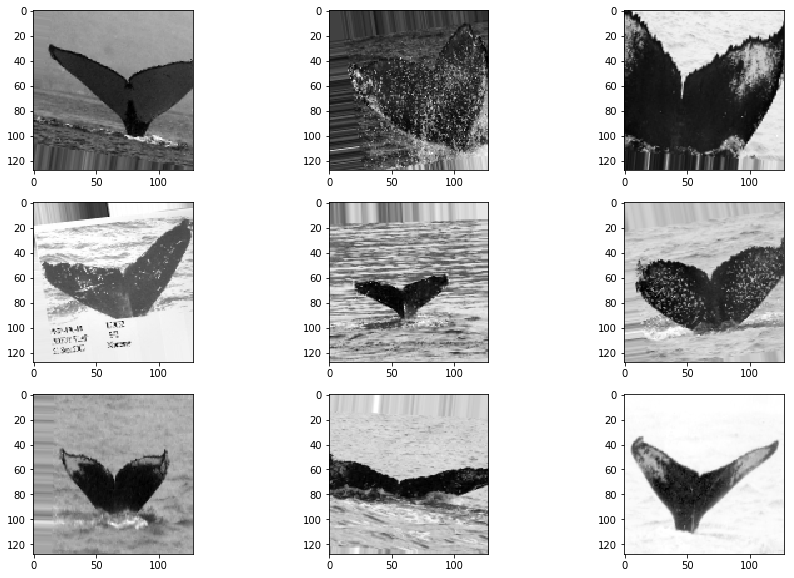

In [40]:
batch_size = 256
target_size = (128, 128, 1)

datagen = ImageDataGenerator(
    rescale=1./255, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest',
    validation_split=.2
)

train_generator = datagen.flow_from_dataframe(
        directory='../input/train',
        subset='training',
        dataframe=binary_dataset,
        target_size=target_size[0:2],
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='binary')

val_generator = datagen.flow_from_dataframe(
        directory='../input/train',
        dataframe=binary_dataset,
        subset='validation',
        target_size=target_size[0:2],
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='binary')

pred_datagen = ImageDataGenerator(rescale=1./255)
pred_generator = pred_datagen.flow_from_dataframe(
        directory='../input/train',
        dataframe=binary_dataset[:100],
        target_size=target_size[0:2],
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='binary')

plt.figure(figsize=(15,10)) 
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(128,128), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

The CNN. Notes:
* optimizer set to Adam with default learning rate of .02 and a learning rate decay at each epoch

In [43]:
inp = Input(shape = target_size)

x1 = Conv2D(16, (9, 9), activation='relu')(inp)
x1 = Conv2D(20, (7, 7), activation='relu')(x1)
x1 = MaxPool2D((2,2))(x1)

x1 = Conv2D(24, (5, 5), activation='relu')(x1)
x1 = Conv2D(32, (3, 3), activation='relu')(x1)
x1 = MaxPool2D((2,2))(x1)


x1 = Conv2D(36, (3, 3), activation='relu')(x1)
x1 = Conv2D(48, (1, 1), activation='relu')(x1)
x1 = MaxPool2D((2,2))(x1)

x = Dropout(.2)(x1)
x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inp, outputs=x)

model.compile(optimizer = 'adam' , loss = "binary_crossentropy", metrics=["binary_accuracy"])
model.build(input_shape = target_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 120, 120, 16)      1312      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 114, 114, 20)      15700     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 57, 57, 20)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 53, 53, 24)        12024     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 51, 51, 32)        6944      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 25, 25, 32)        0         
__________

In [32]:
from keras.models import load_model

#model = load_model('binary.h5')

In [44]:
epochs = 20
import tensorflow as tf

# Creates a graph.
with tf.device('/device:GPU:0'):
    history = model.fit_generator(train_generator, 
                                  epochs=epochs, 
                                  steps_per_epoch=len(train_generator.classes)//batch_size,
                                  validation_steps=len(val_generator.classes)//batch_size,
                                  use_multiprocessing=False,
                                  workers=1,
                                  validation_data=val_generator,
                                  class_weight=class_weights)

Epoch 1/20
79/79 [==============================] - 1275s 16s/step - loss: 0.6550 - binary_accuracy: 0.6212 - val_loss: 0.6574 - val_binary_accuracy: 0.6151
Epoch 2/20
79/79 [==============================] - 1091s 14s/step - loss: 0.6424 - binary_accuracy: 0.6289 - val_loss: 0.6433 - val_binary_accuracy: 0.6424
Epoch 3/20
79/79 [==============================] - 1090s 14s/step - loss: 0.6382 - binary_accuracy: 0.6402 - val_loss: 0.6647 - val_binary_accuracy: 0.6136
Epoch 4/20
79/79 [==============================] - 1091s 14s/step - loss: 0.6360 - binary_accuracy: 0.6437 - val_loss: 0.6398 - val_binary_accuracy: 0.6381
Epoch 5/20
79/79 [==============================] - 1089s 14s/step - loss: 0.6366 - binary_accuracy: 0.6393 - val_loss: 0.6400 - val_binary_accuracy: 0.6333
Epoch 6/20
79/79 [==============================] - 1088s 14s/step - loss: 0.6296 - binary_accuracy: 0.6463 - val_loss: 0.6360 - val_binary_accuracy: 0.6489
Epoch 7/20
40/79 [==============>...............] - ETA: 8

KeyboardInterrupt: 

In [8]:
model.save('binary.h5')

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
pred = model.predict_generator(pred_generator)

s=0
c=0
for i in range(len(pred_generator.classes)):
    #print(pred_generator.classes[i], ' VS ', np.argmax(pred[i]) )
    s += pred_generator.classes[i] * pred_generator.classes[i] - np.argmax(pred[i]) * np.argmax(pred[i])
    c += (pred_generator.classes[i] == np.argmax(pred[i]))

print('rmse: ', np.sqrt(s/len(pred_generator.classes)))
print('class accuracy: ', c/len(pred_generator.classes))

### TO BE CONTINUED